In [1]:
%cd ../..

/home/eli/AnacondaProjects/combinators


In [2]:
import logging

import numpy as np
import probtorch
import torch

from examples.bouncing_ball import bouncing_ball, bouncing_ball_data, bouncing_ball_plots

from combinators.inference import importance, mcmc
from combinators.inference.importance import Propose
from combinators.model import foldable
import combinators.utils as utils

In [3]:
import matplotlib.gridspec as gridspec
from matplotlib.collections import LineCollection

import matplotlib.pyplot as plt

In [4]:
logging.basicConfig(format='%(asctime)s %(message)s', datefmt='%m/%d/%Y %H:%M:%S',
                    level=logging.INFO)

In [5]:
## dataset parameters
T = 100 ## sequence length
num_series = 1
dt = 1 ## \delta t
Boundary = 6 ## unit box is amplified by this value, centered at origin
signal_noise_ratio = 0.2 # the noise is multiplied by this param
D = 2
## Model parameters
K =  4## number of hidden states

In [6]:
## generate time series
x0, y0, init_v, init_v_rand_dir = bouncing_ball_data.intialization(T, num_series, Boundary)
final_mus = np.zeros((num_series, K, D))
final_covs = np.zeros((num_series, K, D, D))
STATEs = np.zeros((num_series, T+1, 4))
Disps = np.zeros((num_series, T, D))
As_true = np.zeros((num_series, 4, 4))
As_pred = np.zeros((num_series, K, K))
for s in range(num_series):
    init_state = np.array([x0[s], y0[s], init_v_rand_dir[s, 0], init_v_rand_dir[s, 1]])
    STATEs[s], Disps[s], As_true[s] = bouncing_ball_data.generate_data(T, dt, init_state, Boundary, signal_noise_ratio)

In [7]:
num_particles = (100,)

In [8]:
init_bouncing_ball = bouncing_ball.InitBouncingBall(batch_shape=num_particles)

In [9]:
bouncing_ball_step = bouncing_ball.BouncingBallStep(batch_shape=num_particles)

In [10]:
def proposal_step():
    return bouncing_ball.ProposalStep(batch_shape=num_particles, name='BouncingBallStep')

In [11]:
prior_init_params = {
    'position_0': {
        'loc': torch.zeros(2),
        'scale': torch.ones(2),
    },
    'alpha_0': {
        'concentration': torch.ones(4),
    },
    'alpha_1': {
        'concentration': torch.ones(4),
    },
    'alpha_2': {
        'concentration': torch.ones(4),
    },
    'alpha_3': {
        'concentration': torch.ones(4),
    },
    'alpha_4': {
        'concentration': torch.ones(4),
    },
    'directions': {
        'loc': {
            'loc': torch.ones(2),
            'scale': torch.ones(2),
        },
        'cov': {
            'loc': torch.eye(2).expand(4, 2, 2),
            'scale': torch.ones(4, 2, 2),
        },
    },
}

In [12]:
variational_init_params = {
    'position_0': {
        'loc': torch.zeros(2),
        'scale': torch.ones(2),
    },
    'alpha_0': {
        'concentration': torch.ones(4),
    },
    'alpha_1': {
        'concentration': torch.ones(4),
    },
    'alpha_2': {
        'concentration': torch.ones(4),
    },
    'alpha_3': {
        'concentration': torch.ones(4),
    },
    'alpha_4': {
        'concentration': torch.ones(4),
    },
    'directions': {
        'loc': {
            'loc': torch.ones(2),
            'scale': torch.ones(2),
        },
        'cov': {
            'loc': torch.eye(2).expand(4, 2, 2),
            'scale': torch.ones(4, 2, 2),
        },
    },
}

In [13]:
def generate_trajectory_trace(s):
    trajectory = torch.Tensor(STATEs[s])
    displacements = torch.Tensor(Disps[s])

    data = {}

    for i, point in enumerate(trajectory):
        data['position_%d' % i] = torch.Tensor(point[:2])
        if i >= 1:
            data['displacement_%d' % i] = displacements[i-1]
    
    return trajectory, displacements, data

In [14]:
def accumulate_trajectory(inference):
    result = torch.zeros(num_particles[0], len(trajectory), 2)
    result[:, 0] = inference['Reduce/Step(0)/InitBouncingBall']['position_0'].value
    for t in range(len(trajectory) - 1):
        result[:, t+1] = result[:, t] + inference['Reduce/Step(%d)/BouncingBallStep' % t]['displacement_%d' % (t+1)].value
    return result

In [15]:
def graph_position_trajectory(positions, T, s):
    gs = gridspec.GridSpec(2, 2)
    fig1 = plt.figure(figsize=(5, 5))
    ax1 = fig1.gca()

    ax1.scatter(positions[:, 0], positions[:, 1], c=np.arange(T))
    ax1.set_xlim([-Boundary, Boundary])
    ax1.set_ylim([-Boundary, Boundary])
    #ax1.set_xticks([])
    #ax1.set_yticks([])
    ax1.set_ylabel('y(t)')
    ax1.set_xlabel('x(t)')
    plt.savefig('position_trajectory_%d.pdf' % s)

In [16]:
def graph_displacement_trajectories(velocity_steps, displacements, T, s):
    fig2, (ax2, ax3) = plt.subplots(2, 1, sharex=True, sharey=True, figsize=(5, 5))

    dx_lc = LineCollection(velocity_steps[:, :, :2].numpy())
    dx_lc.set_array(np.arange(T - 1))
    ax2.add_collection(dx_lc)
    ax2.scatter(np.arange(T), displacements[:, 0], c=np.arange(T), s=10)
    #ax2.set_xlabel('t')
    ax2.set_ylabel('Δx')

    dy_lc = LineCollection(velocity_steps[:, :, 0:3:2].numpy())
    dy_lc.set_array(np.arange(T-1))
    ax3.add_collection(dy_lc)
    ax3.scatter(np.arange(T), displacements[:, 1], c=np.arange(T), s=10)
    ax3.set_xlabel('Time')
    ax3.set_ylabel('Δy')

    plt.savefig('time_vs_displacement_%d.pdf' % s)

In [17]:
def graph_velocity_frequencies(directions):
    fig = plt.figure(figsize=(6, 6))
    ax = fig.gca()

    ax.scatter(init_v[:, 0], init_v[:, 1], label='z=1')
    ax.scatter(init_v[:, 0], -init_v[:, 1], label='z=2')
    ax.scatter(-init_v[:, 0], -init_v[:, 1], label='z=3')
    ax.scatter(-init_v[:, 0], init_v[:, 1], label='z=4')
    colors = ['b', 'orange', 'g', 'r', 'k']
    for k in range(K):
        ax.scatter(directions[:, k, 0], directions[:, k, 1], c=colors[k], marker='x')

    ax.set_xlabel('X velocity')
    ax.set_ylabel('Y velocity')
    ax.set_xlim([-1.1, 1.1])
    ax.set_ylim([-1.1, 1.1])
    ax.legend(loc='upper center', bbox_to_anchor=(0.5, 1.15), ncol=4)
    plt.savefig('velocity_frequencies.pdf')

In [18]:
def training_initializer(prior_params, variational_params):
    prior_params['position_0']['loc'] = data['position_0']
    variational_params['position_0']['loc'] = data['position_0']
    init_bouncing_ball = bouncing_ball.InitBouncingBall(params=prior_params, trainable=False, batch_shape=num_particles)
    init_proposal = bouncing_ball.InitBouncingBall(params=variational_params, trainable=True, batch_shape=num_particles)
    return importance.Propose(init_bouncing_ball, init_proposal)

In [19]:
def training_step():
    return importance.Propose(bouncing_ball_step, proposal_step())

In [20]:
def training_model(prior_params, variational_params):
    initializer = training_initializer(prior_params, variational_params)
    return foldable.Reduce(foldable.Step(training_step(), initializer=initializer), lambda: range(T))

In [21]:
def generative_model(data, params):
    params['position_0']['loc'] = data['position_0']
    init_bouncing_ball = bouncing_ball.InitBouncingBall(params=params, trainable=False, batch_shape=num_particles)
    generative_step = foldable.Step(bouncing_ball_step, initializer=init_bouncing_ball)
    return foldable.Reduce(generative_step, lambda: range(T))

In [22]:
def proposal_model(data, params):
    params['position_0']['loc'] = data['position_0']
    init_proposal = bouncing_ball.InitBouncingBall(params=params, trainable=True, batch_shape=num_particles)
    return foldable.Reduce(foldable.Step(proposal_step(), initializer=init_proposal), lambda: range(T))

In [23]:
def posterior_model(data, params, step_proposal):
    generative_params = prior_init_params.copy()
    generative_params['position_0']['loc'] = data['position_0']
    
    generative_init = bouncing_ball.InitBouncingBall(params=generative_params, trainable=False,
                                                     batch_shape=num_particles)
    params['position_0']['loc'] = data['position_0']
    proposal_init = bouncing_ball.InitBouncingBall(params=params, trainable=False, batch_shape=num_particles)
    init_posterior = Propose(generative_init, proposal_init)
    
    step_posterior = Propose(bouncing_ball_step, step_proposal)
    
    reducer = foldable.Reduce(foldable.Step(step_posterior, initializer=init_posterior), lambda: range(T))
    return mcmc.resample_move_smc(reducer)

06/10/2019 16:15:22 EUBO=5.56549194e+02 at epoch 1
06/10/2019 16:15:24 EUBO=5.15056641e+02 at epoch 2
06/10/2019 16:15:26 EUBO=5.22995239e+02 at epoch 3
06/10/2019 16:15:28 EUBO=5.20631592e+02 at epoch 4
06/10/2019 16:15:30 EUBO=4.42758057e+02 at epoch 5
06/10/2019 16:15:32 EUBO=4.18644562e+02 at epoch 6
06/10/2019 16:15:34 EUBO=4.33301056e+02 at epoch 7
06/10/2019 16:15:36 EUBO=5.53919983e+02 at epoch 8
06/10/2019 16:15:38 EUBO=5.23709473e+02 at epoch 9
06/10/2019 16:15:40 EUBO=4.14700775e+02 at epoch 10
06/10/2019 16:15:42 EUBO=4.65540833e+02 at epoch 11
06/10/2019 16:15:44 EUBO=3.84985931e+02 at epoch 12
06/10/2019 16:15:46 EUBO=5.54746643e+02 at epoch 13
06/10/2019 16:15:47 EUBO=4.99011871e+02 at epoch 14
06/10/2019 16:15:50 EUBO=4.94197083e+02 at epoch 15
06/10/2019 16:15:52 EUBO=5.24345825e+02 at epoch 16
06/10/2019 16:15:54 EUBO=3.99077026e+02 at epoch 17
06/10/2019 16:15:56 EUBO=4.60525391e+02 at epoch 18
06/10/2019 16:15:57 EUBO=4.79641937e+02 at epoch 19
06/10/2019 16:15:59 E

Epoch   374: reducing learning rate of group 0 to 5.0000e-03.


06/10/2019 16:27:23 EUBO=3.97327972e+02 at epoch 376
06/10/2019 16:27:24 EUBO=3.24079559e+02 at epoch 377
06/10/2019 16:27:26 EUBO=3.47707397e+02 at epoch 378
06/10/2019 16:27:28 EUBO=3.15158386e+02 at epoch 379
06/10/2019 16:27:30 EUBO=4.16740540e+02 at epoch 380
06/10/2019 16:27:32 EUBO=3.31575256e+02 at epoch 381
06/10/2019 16:27:34 EUBO=3.61051208e+02 at epoch 382
06/10/2019 16:27:36 EUBO=3.36372681e+02 at epoch 383
06/10/2019 16:27:38 EUBO=2.77084595e+02 at epoch 384
06/10/2019 16:27:40 EUBO=3.85345276e+02 at epoch 385
06/10/2019 16:27:42 EUBO=3.83904144e+02 at epoch 386
06/10/2019 16:27:44 EUBO=4.12948486e+02 at epoch 387
06/10/2019 16:27:46 EUBO=3.81897247e+02 at epoch 388
06/10/2019 16:27:49 EUBO=3.94277344e+02 at epoch 389
06/10/2019 16:27:51 EUBO=3.87445618e+02 at epoch 390
06/10/2019 16:27:53 EUBO=3.40879944e+02 at epoch 391
06/10/2019 16:27:55 EUBO=2.79088501e+02 at epoch 392
06/10/2019 16:27:58 EUBO=3.99158539e+02 at epoch 393
06/10/2019 16:28:01 EUBO=3.44654846e+02 at epo

Epoch   713: reducing learning rate of group 0 to 2.5000e-03.


06/10/2019 16:38:00 EUBO=3.93823090e+02 at epoch 715
06/10/2019 16:38:01 EUBO=3.26494263e+02 at epoch 716
06/10/2019 16:38:03 EUBO=4.01192719e+02 at epoch 717
06/10/2019 16:38:05 EUBO=3.05852661e+02 at epoch 718
06/10/2019 16:38:07 EUBO=3.22425964e+02 at epoch 719
06/10/2019 16:38:09 EUBO=3.70974670e+02 at epoch 720
06/10/2019 16:38:10 EUBO=3.57245544e+02 at epoch 721
06/10/2019 16:38:12 EUBO=3.55345306e+02 at epoch 722
06/10/2019 16:38:14 EUBO=2.71572845e+02 at epoch 723
06/10/2019 16:38:16 EUBO=3.20649963e+02 at epoch 724
06/10/2019 16:38:18 EUBO=3.97819183e+02 at epoch 725
06/10/2019 16:38:19 EUBO=3.42400452e+02 at epoch 726
06/10/2019 16:38:21 EUBO=3.22396515e+02 at epoch 727
06/10/2019 16:38:23 EUBO=3.77188202e+02 at epoch 728
06/10/2019 16:38:25 EUBO=3.14920929e+02 at epoch 729
06/10/2019 16:38:27 EUBO=2.84266357e+02 at epoch 730
06/10/2019 16:38:28 EUBO=3.35926361e+02 at epoch 731
06/10/2019 16:38:30 EUBO=3.70450012e+02 at epoch 732
06/10/2019 16:38:32 EUBO=3.49773254e+02 at epo

Epoch   914: reducing learning rate of group 0 to 1.2500e-03.


06/10/2019 16:44:04 EUBO=2.62355255e+02 at epoch 916
06/10/2019 16:44:06 EUBO=3.59670227e+02 at epoch 917
06/10/2019 16:44:07 EUBO=3.96164154e+02 at epoch 918
06/10/2019 16:44:09 EUBO=3.62008972e+02 at epoch 919
06/10/2019 16:44:11 EUBO=3.10165833e+02 at epoch 920
06/10/2019 16:44:13 EUBO=2.78015076e+02 at epoch 921
06/10/2019 16:44:15 EUBO=2.94242157e+02 at epoch 922
06/10/2019 16:44:16 EUBO=3.11642151e+02 at epoch 923
06/10/2019 16:44:18 EUBO=4.14091156e+02 at epoch 924
06/10/2019 16:44:20 EUBO=2.55808334e+02 at epoch 925
06/10/2019 16:44:22 EUBO=3.40857117e+02 at epoch 926
06/10/2019 16:44:24 EUBO=3.60710510e+02 at epoch 927
06/10/2019 16:44:25 EUBO=3.13621765e+02 at epoch 928
06/10/2019 16:44:27 EUBO=3.12441284e+02 at epoch 929
06/10/2019 16:44:29 EUBO=3.55401154e+02 at epoch 930
06/10/2019 16:44:31 EUBO=3.24920258e+02 at epoch 931
06/10/2019 16:44:33 EUBO=3.20819244e+02 at epoch 932
06/10/2019 16:44:35 EUBO=3.38783722e+02 at epoch 933
06/10/2019 16:44:36 EUBO=2.26824051e+02 at epo

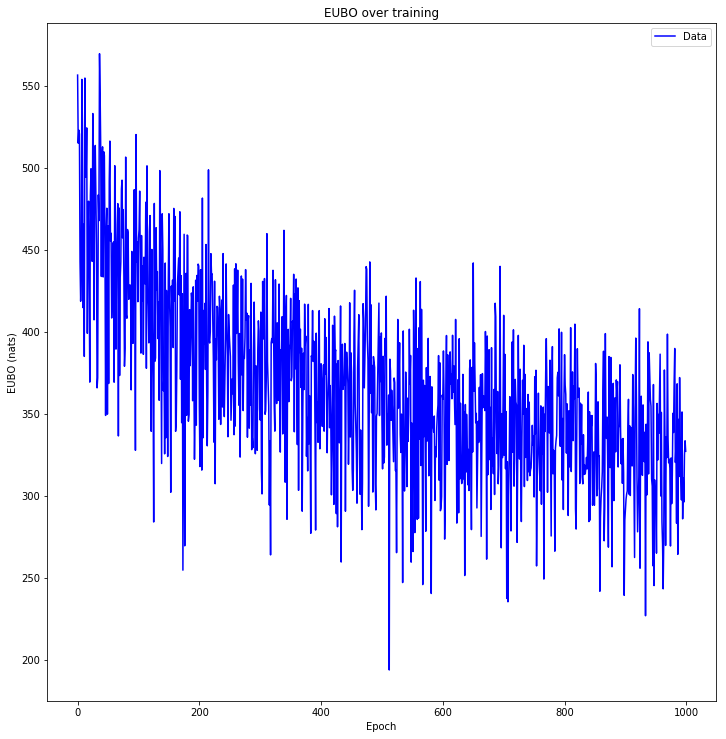

In [24]:
modal_directions = torch.zeros(num_series, K, 2)

for s in range(num_series):
    trajectory, displacements, data = generate_trajectory_trace(s)

    importance_sampler = training_model(prior_init_params.copy(), variational_init_params.copy())
    
    inference, trained_params, (_, eubos) = importance.variational_importance(
        importance_sampler, 1000, data,
        use_cuda=False, lr=1e-2, bound='eubo',
        patience=200,
    )
    utils.plot_evidence_bounds(eubos.numpy(), False)
    
    bouncing_ball_posterior = posterior_model(data, trained_params, importance_sampler.folder.operator.proposal)
    (positions, _, A_pred, final_mu, final_cov), inference, _ = bouncing_ball_posterior(data=data)
    As_pred[s] = A_pred.mean(dim=0).detach().numpy()
    final_mus[s] = final_mu.mean(dim=0).detach().numpy()
    final_covs[s] = final_cov.mean(dim=0).detach().numpy()
    inferred_trajectory = accumulate_trajectory(inference)
    
    positions = inferred_trajectory[:, 1:, :].mean(dim=0).cpu().detach()
    displacements = torch.stack([inference['Reduce/Step(%d)/BouncingBallStep' % t]['displacement_%d' % (t+1)].value for t in range(T)], dim=1).mean(dim=0).cpu().detach()
    step_numbers = torch.stack((torch.arange(T), torch.arange(T) + 1), dim=-1)
    velocity_srcs = torch.cat((torch.arange(T-1).unsqueeze(1).to(displacements), displacements[:-1]), dim=1)
    velocity_dests = torch.cat((torch.arange(T-1).unsqueeze(1).to(displacements) + 1, displacements[1:]), dim=1)
    velocity_steps = torch.stack((velocity_srcs, velocity_dests), dim=1)
    
    graph_position_trajectory(positions, T, s)
    graph_displacement_trajectories(velocity_steps, displacements, T, s)
    
    modal_directions[s] = bouncing_ball.reflect_directions(trained_params['directions']['loc']['loc'].unsqueeze(0)).squeeze(0)
    
    plt.close('all')

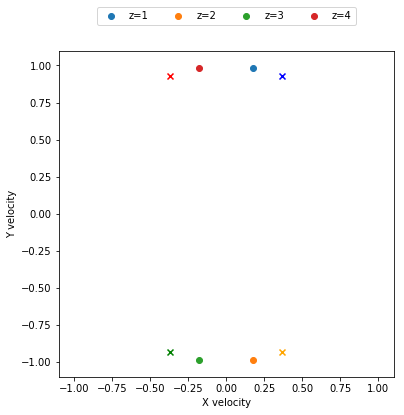

In [25]:
graph_velocity_frequencies(modal_directions.detach())

In [26]:
fs = 3 ## figure size
vmax = 0.3 ## cmap maximum value, to make off-diagonal elements more visible
width_space = 0.05 # space between figures
height_space = 0.05 # space between figures
cov_flag = False # plot the covariances or not
legend_flag = False # plot the legend bar or not
save_flag = True ## save or not

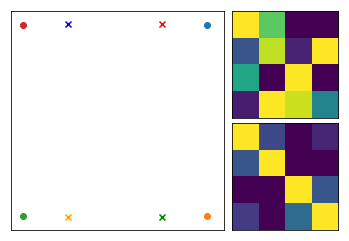

In [27]:
## plot method 1
bouncing_ball_plots.plot_circle_transition(init_v, final_mus, final_covs,
                                           As_pred, As_true, K, fs, vmax, width_space, height_space, cov_flag, legend_flag, save_flag)

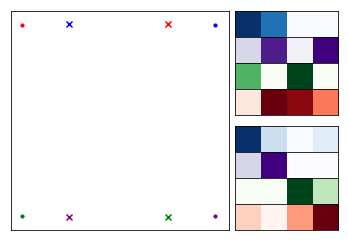

In [28]:
## plot method 2
bouncing_ball_plots.plot_circle_transition_colorcode(init_v, final_mus, final_covs, As_pred, As_true, K, fs, vmax, width_space, height_space, cov_flag, legend_flag, save_flag)

In [29]:
def plot_circle_transition_colorcode(init_v, final_mus, final_covs, As_pred, As_true, K, fs, vmax, width_space, height_space, cov_flag, legend_flag, save_flag):

    As_infer = As_pred / As_pred.sum(-1)[:, :, None]
    As_infer = As_infer.mean(0)
    As_true_ave = As_true.mean(0)

    fig = plt.figure(figsize=(fs*1.5 + width_space,fs + height_space))
    gs1 = gridspec.GridSpec(1, 1)
    # , width_ratios=[2,1], height_ratios=[1,1]
    gs1.update(left=0.0, bottom=0.0, right=(2/3), top=1.0, wspace=width_space, hspace=height_space)
    ax1 = fig.add_subplot(gs1[0])

    # ax3 = fig.add_subplot(gs[1, 1])
    ax1.set_xticks([])
    ax1.set_yticks([])

    gs2 = gridspec.GridSpec(4, 1)
    gs2.update(left=2/3 + (1/3)*width_space, bottom=0.5+(1/2)*width_space, right=1.0, top=1.0, wspace=0, hspace=0)
    ax2 = fig.add_subplot(gs2[0, 0])
    ax2.set_xticks([])
    ax2.set_yticks([])
    ax3 = fig.add_subplot(gs2[1, 0])
    ax3.set_xticks([])
    ax3.set_yticks([])
    ax4 = fig.add_subplot(gs2[2, 0])
    ax4.set_xticks([])
    ax4.set_yticks([])
    ax5 = fig.add_subplot(gs2[3, 0])
    ax5.set_xticks([])
    ax5.set_yticks([])

    gs3 = gridspec.GridSpec(4, 1)
    gs3.update(left=2/3 + (1/3)*width_space, bottom=0.0, right=1.0, top=0.5 - (1/2)*width_space, wspace=0, hspace=0)
    ax6 = fig.add_subplot(gs3[0, 0])
    ax6.set_xticks([])
    ax6.set_yticks([])
    ax7 = fig.add_subplot(gs3[1, 0])
    ax7.set_xticks([])
    ax7.set_yticks([])
    ax8 = fig.add_subplot(gs3[2, 0])
    ax8.set_xticks([])
    ax8.set_yticks([])
    ax9 = fig.add_subplot(gs3[3, 0])
    ax9.set_xticks([])
    ax9.set_yticks([])
    markersize = 10.0
    colors = ['b', 'Purple', 'g', 'r']
    ## plot left one
    ax1.scatter(init_v[:,0], init_v[:,1], s=markersize, color=colors[0], label='z=1')
    ax1.scatter(init_v[:,0], -init_v[:,1], s=markersize, color=colors[1], label='z=2')
    ax1.scatter(-init_v[:,0], -init_v[:,1], s=markersize, color=colors[2], label='z=3')
    ax1.scatter(-init_v[:,0], init_v[:,1], s=markersize, color=colors[3], label='z=4')

    for k in range(K):
        ax1.scatter(final_mus[:,k,0], final_mus[:,k,1], c=colors[k], marker='x')
    if cov_flag:
        for k in range(K):
            for s in range(num_series):
                plot_cov_ellipse(cov=final_covs[s, k, :, :], pos=final_mus[s, k, :], nstd=0.3, ax=ax1, alpha=0.3)
    #    ax1.set_xlabel('x velocity')
    #    ax1.set_ylabel('y velocity')
    if legend_flag:
        ax1.legend(loc='upper center', bbox_to_anchor=(0.75, 1.15), ncol=4)

    ax2.imshow(As_infer[None, 0,:], cmap='Blues', vmin=0, vmax=vmax)
    ax3.imshow(As_infer[None, 1,:], cmap='Purples', vmin=0, vmax=vmax)
    ax4.imshow(As_infer[None, 2,:], cmap='Greens', vmin=0, vmax=vmax)
    ax5.imshow(As_infer[None, 3,:], cmap='Reds', vmin=0, vmax=vmax)

    ax6.imshow(As_true_ave[None, 0,:], cmap='Blues', vmin=0, vmax=vmax)
    ax7.imshow(As_true_ave[None, 1,:], cmap='Purples', vmin=0, vmax=vmax)
    ax8.imshow(As_true_ave[None, 2,:], cmap='Greens', vmin=0, vmax=vmax)
    ax9.imshow(As_true_ave[None, 3,:], cmap='Reds', vmin=0, vmax=vmax)

    if save_flag:
        fig.savefig('combinator_results.pdf', dpi=600, bbox_inches='tight')
        fig.savefig('combinator_results.svg', dpi=600, bbox_inches='tight')
        fig.savefig('combinator_results.png', dpi=600, bbox_inches='tight')

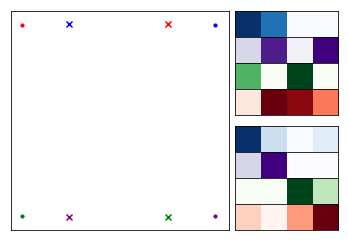

In [30]:
## plot method 2
plot_circle_transition_colorcode(init_v, final_mus, final_covs, As_pred, As_true, K, fs, vmax, width_space, height_space, cov_flag, legend_flag, save_flag)